# Makemore Tutorial Part 2
## Based on 'A Neural Probabilistic Language Model'

In [5]:

"""
Model structure from 'A Neural Probabilistic Language Model'


            i-th output = P(Wt = i | context)
                        |
    [_______fully_connected_softmax________]                    <- (most computation/largest layer)
                        |
                        |
                        |
[_____________fully_connected_tanh________________]
    |                   |                   |
    |                   |                   |
[C(Wt-n+1)]  ...    [C(Wt-2)]            [C(Wt-1)]
 |                    |                    |
 |__________(C)_______|_________(C)________| 
 |                    |                    |
[  ]                 [  ]                 [  ]  
indx for Wt-n+1  ...  for Wt-2              for Wt-1
"""

"\nModel structure from 'A Neural Probabilistic Language Model'\n\n            i-th output = P(Wt = i | context)\n                        |\n    [_______fully_connected_softmax________]                   <- (most computation/largest layer)\n                        |\n                        |\n                        |\n[_____________fully_connected_tanh________________]\n    |                   |                   |\n    |                   |                   |\n[C(Wt-n+1)]         [C(Wt-2)]            [C(Wt-1)]\n |                    |                    |\n |__________(C)_______|_________(C)________| \n |                    |                    |\n[  ]                 [  ]                 [  ]  \nindx for Wt-n+1      for Wt-2              for Wt-1\n"

`C` is a 'Loop-Up Table'. In the paper, it is ~ 17,000 rows long, one row for every *word* in their corpus, and it is 30 columns wide - 30 since each word is embedded into a 30-dimensional space in their model.  
`C`'s parameters are shared across all of the input words and updated through backprop. Then, each input word is used to 'index' C to get the embedding for the given word. Thus, each word index is converted to the 30-dim embedding vector corresponding to it.  
Thus, the network's actual 'input layer' is a vector of 3 (the number of words) * 30 = 90 total inputs.  
The hidden layer is a fully connected + `tanh` layer as seen above, and the size is a hyperparameter.  
It is connected to a fully connected + `softmax` layer. Since, in the paper, there are 17,000 possible words to predict, this layer has 17000 neurons all fully connected to the hidden layer - thus a lot of params.  

We will be using this process but staying at the character level. 

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

import random
import math

In [2]:
words = open('../makemore_data/names.txt').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
# Vocab
chars = sorted(list(set(''.join(words)))) ##unique characters ordered
stoi = {s:i+1 for i, s in enumerate(chars)} ##create dictionary mapping from char to int
stoi['.'] = 0 ##just one special character for start and end of word
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [31]:
X, Y = [], []
block_size = 3
for w in words[:5]:
    print(f"{w}:")

    context = [0] * block_size #start with padded context of just 0 tokes ('.')
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), "-->", itos[ix])
        context = context[1:] + [ix] #crop the context vector and append the new index


X = torch.tensor(X)
Y = torch.tensor(Y)

n_samples = X.shape[0]

emma:
... --> e
..e --> m
.em --> m
emm --> a
mma --> .
olivia:
... --> o
..o --> l
.ol --> i
oli --> v
liv --> i
ivi --> a
via --> .
ava:
... --> a
..a --> v
.av --> a
ava --> .
isabella:
... --> i
..i --> s
.is --> a
isa --> b
sab --> e
abe --> l
bel --> l
ell --> a
lla --> .
sophia:
... --> s
..s --> o
.so --> p
sop --> h
oph --> i
phi --> a
hia --> .


## Background

In [32]:
X.shape, Y.shape, n_samples

(torch.Size([32, 3]), torch.Size([32]), 32)

In [33]:
# Let's embed our 26 characters into a smaller space, for example 2d
## randomly initialize with 27 rows (1 for each ch) and 2 cols - based on dim of embedding space
C = torch.randn((27, 2))

In [34]:
# To index into C....
C[5] # is equivalent to:
F.one_hot(torch.tensor([5]), num_classes=27).float() @ C

## So we can either think of the integer as indexing into lookup-table C or think of C as a first layer which we feed one-hot integers
## But indexing is faster!

tensor([[-0.1990, -1.4198]])

In [35]:
# We can index torch tensors with lists or even tensors:
print(f"{X[10] = }")

print(f"{ C[X[10]] = }")

X[10] = tensor([ 9, 22,  9])
 C[X[10]] = tensor([[-0.5013,  1.1879],
        [-0.2268,  1.6490],
        [-0.5013,  1.1879]])


In [36]:
# thus, to get our full embedding we can simply do:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [37]:
# First layer takes 6 inputs (3 input words * 2-dimensional embedding)
# The number of neurons is a parameter we control
layer1_neurons = 100
W1 = torch.randn((6, layer1_neurons))
b1 = torch.randn(layer1_neurons)

In [38]:
# emb @ W1 + b1 will NOT work since the embeddins are not of the correct shape
# we can concatenate the second 2 dimensions - ie, the 2d embeddings for each input word can be stacked together into one 'row'
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1).shape
## Each of these sliced tensors will have shape (32, 2) so we concatenate along dimension 1, not 0
## But this is dependent on the block size

torch.Size([32, 6])

In [39]:
# instead we could use torch.unbind, which removes a dimension and gives us a list, just like the manual one we made above
print( f"{len(torch.unbind(emb, dim=1)) = }" )
torch.cat(torch.unbind(emb, dim=1), 1).shape
## but this creates a whole new tensor, and is thus mem inefficient

len(torch.unbind(emb, dim=1)) = 3


torch.Size([32, 6])

In [41]:
# A better way: use .view which is extemely memory effecient
emb.view(32, block_size*2).shape ##which concatenates in just the right way

torch.Size([32, 6])

## Put it together

In [42]:
g = torch.Generator().manual_seed(2147483647)
# Let's embed our 26 characters into a smaller space, for example 2d
## randomly initialize with 27 rows (1 for each ch) and 2 cols - based on dim of embedding space

# EMBEDDINGS
emb_dim = 2
C = torch.randn((27, emb_dim), generator=g)
# Get embeddings
emb = C[X]

# HIDDEN LAYER
# First layer takes 6 inputs (3 input words * 2-dimensional embedding)
# The number of neurons is a parameter we control
layer1_neurons = 100
W1 = torch.randn((6, layer1_neurons), generator=g)
b1 = torch.randn(layer1_neurons, generator=g)

h = torch.tanh( emb.view(-1, block_size*emb_dim) @ W1 + b1 )   
##emb goes to (32, 6), since -1 makes torch infer the dim
##b1 is broadcasted to (1, 100) and added element wise to the (32, 100) matrix produced by the mat mul

print( h.shape )
print( torch.max(h), torch.min(h) ) ##tanh squeezes between -1, 1

torch.Size([32, 100])
tensor(1.) tensor(-1.)


In [43]:
# OUTPUT LAYER
# Create final layer: receives # inputs = layer 1's neurons, and has 27 neurons (1 for each chr)
W2 = torch.randn((layer1_neurons, 27), generator=g)
b2 = torch.randn(27, generator=g)

# Logits are the hidden layer mat multiplied by the output layer (+ bias)
logits = h @ W2 + b2

# Softmax the logits
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)

print(probs.shape) ##n_samples, 27 possible characters

parameters = [C, W1, b1, W2, b2]
print(f"Model params = { sum(p.nelement() for p in parameters) }")

torch.Size([32, 27])
Model params = 3481


In [44]:
# LOSS
## before: loss = -prob[torch.arange(n_samples), Y].log().mean()
## equivalent: (more mem efficient forward & backprop, and safer)
loss = F.cross_entropy(logits, Y)
loss

tensor(17.7697)

# Full Training

In [45]:
# Vocab
chars = sorted(list(set(''.join(words)))) ##unique characters ordered
stoi = {s:i+1 for i, s in enumerate(chars)} ##create dictionary mapping from char to int
stoi['.'] = 0 ##just one special character for start and end of word
itos = {i:s for s, i in stoi.items()}

# Data
block_size = 3 ## context length: how many chars do we use to predict the next?

X, Y = [], []
for w in words[:]:
    # print(f"{w}:")

    context = [0] * block_size #start with padded context of just 0 tokes ('.')
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), "-->", itos[ix])
        context = context[1:] + [ix] #crop the context vector and append the new index


X = torch.tensor(X)
Y = torch.tensor(Y)

n_samples = X.shape[0]
print(n_samples)

228146


In [46]:
g = torch.Generator().manual_seed(2147483647)
emb_dim = 2
layer1_neurons = 100

C = torch.randn((27, emb_dim), generator=g)
W1 = torch.randn((6, layer1_neurons), generator=g)
b1 = torch.randn(layer1_neurons, generator=g)
W2 = torch.randn((layer1_neurons, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]
print(f"Model params = { sum(p.nelement() for p in parameters) }")

Model params = 3481


In [47]:
# LR Grid Search
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [48]:
batch_size = 32
steps = 1000
# Let's try a different learning rate for each iteration to see which performs best
lri = []
lossi = []

for p in parameters:
    p.requires_grad = True

print("loss:")
for i in range(steps):
    # Minibatch construct
    if batch_size is not None:
        batch_ix = torch.randint(0, X.shape[0], (batch_size, )) ##32 randints between 0 and length of data
    else:
        batch_ix=range(0,X.shape[0])
    # Forward pass
    emb = C[X[batch_ix]]
    h = torch.tanh( emb.view(-1, block_size*emb_dim) @ W1 + b1 )   
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[batch_ix])

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    # track stats to tune lr - shows learning rate of 0.1 looks good
    lri.append(lre[i])
    lossi.append(loss.item())

print(loss.item(), end=" ")

loss:
5.844039440155029 

In [49]:
# Eval on full data
emb = C[X[:]]
h = torch.tanh( emb.view(-1, block_size*emb_dim) @ W1 + b1 )   
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y[:])
loss.item()

7.318695545196533

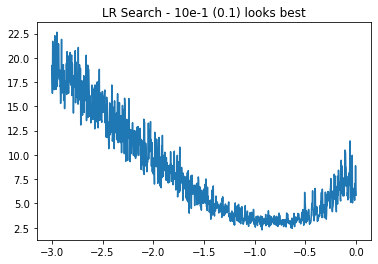

In [50]:
plt.plot(lri, lossi)
plt.title("LR Search - 10e-1 (0.1) looks best")
plt.show()

# Train, Valid, Test split

In [5]:
def make_data(words, block_size=3):
    chars = sorted(list(set(''.join(words)))) ##unique characters ordered
    stoi = {s:i+1 for i, s in enumerate(chars)} ##create dictionary mapping from char to int
    stoi['.'] = 0 ##just one special character for start and end of word
    itos = {i:s for s, i in stoi.items()}

    # Data
    ## block_size = context length: how many chars do we use to predict the next?

    X, Y = [], []
    for w in words[:]:
        # print(f"{w}:")

        context = [0] * block_size #start with padded context of just 0 tokes ('.')
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), "-->", itos[ix])
            context = context[1:] + [ix] #crop the context vector and append the new index


    X = torch.tensor(X)
    Y = torch.tensor(Y)

    n_samples = X.shape[0]
    print(f"{ n_samples = }")

    return X, Y


def split_samples(inputs, labels, frac=0.8, seed=123):
    "Split xs and ys (inputs and labels) into train and test sets"
    
    assert len(inputs)==len(labels), f"{len(inputs) = } which does not match {len(labels) = }"
    # generate a list of indices to exclude. Turn in into a set for O(1) lookup time
    random.seed(seed)
    indx = list(set(random.sample(list(range(len(inputs))), int(frac*len(inputs)))))

    x_mask = torch.zeros((len(inputs)), dtype=torch.bool) #False
    x_mask[indx] = True

    y_mask = torch.zeros((len(inputs)), dtype=torch.bool) #False
    y_mask[indx] = True

    train_x = inputs[x_mask]
    train_y = labels[y_mask]

    test_x = inputs[~x_mask]
    test_y = labels[~y_mask]

    return train_x, train_y, test_x, test_y

In [52]:
# MAKING DATA & SPLITTING
block_size = 3
X, Y = make_data(words, block_size)

Xtr, Ytr, Xte, Yte = split_samples(X, Y, 0.8)
Xdev, Ydev, Xte, Yte = split_samples(Xte, Yte, 0.5)

print("Train:", Xtr.shape[0]/X.shape[0], 
      "Dev:", Xdev.shape[0]/X.shape[0],
      "Test:", Xte.shape[0]/X.shape[0])

print(X.shape)

 n_samples = 228146
Train: 0.7999964934734775 Dev: 0.10000175326326124 Test: 0.10000175326326124
torch.Size([228146, 3])


In [53]:
# INITIALIZE NET
g = torch.Generator().manual_seed(2147483647)
emb_dim = 10
layer1_neurons = 200

C = torch.randn((27, emb_dim), generator=g)
W1 = torch.randn((emb_dim*block_size, layer1_neurons), generator=g)
b1 = torch.randn(layer1_neurons, generator=g)
W2 = torch.randn((layer1_neurons, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]
print(f"Model params = { sum(p.nelement() for p in parameters) }")


lossi = []
stepi = []

Model params = 11897


In [54]:
# TRAIN
batch_size = 64
steps = 50000

for p in parameters:
    p.requires_grad = True

print("loss:")
for i in range(steps):
    # Minibatch construct
    if batch_size is not None:
        batch_ix = torch.randint(0, Xtr.shape[0], (batch_size, )) ##32 randints between 0 and length of data
    else:
        batch_ix=range(0,Xtr.shape[0])
    # Forward pass
    emb = C[Xtr[batch_ix]]
    h = torch.tanh( emb.view(-1, block_size*emb_dim) @ W1 + b1 )   
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[batch_ix])

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.01 
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    stepi.append(i)
    lossi.append(loss.log10().item())

print(loss.item(), end=" ")

loss:
2.180905342102051 

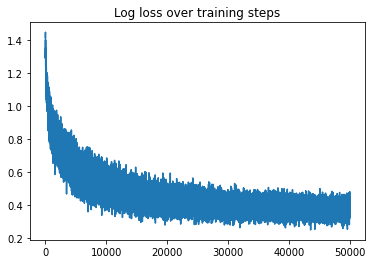

In [55]:
plt.plot(lossi)
plt.title("Log loss over training steps")
plt.show()

In [56]:
# Eval on dev set
emb = C[Xdev[:]]
h = torch.tanh( emb.view(-1, block_size*emb_dim) @ W1 + b1 )   
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev[:])
print("Dev set loss:", loss.item())

Dev set loss: 2.396174192428589


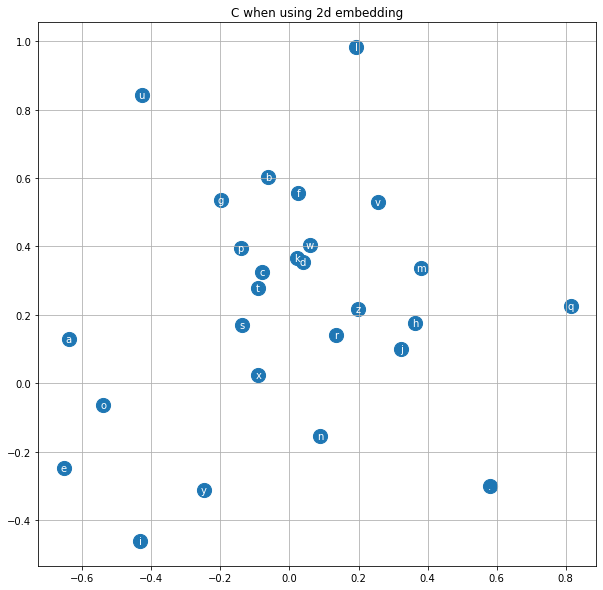

In [357]:
# Let's visualize the character embeddings we trained while they're 2 dimensional
# C_2d = C  ##not a great way of saving this object but this is an experimental notebook

plt.figure(figsize=(10, 10))
plt.scatter(C_2d[:,0].data, C_2d[:,1].data, s=200)
for i in range(C_2d.shape[0]):
    plt.text(C_2d[i,0].item(), C_2d[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.title("C when using 2d embedding")
plt.grid('minor')

## Increasing the dimensionality could improve performance... go up and change it

In [57]:
# Sample from the model
for _ in range(10):
    out_word = "."
    context = [0] * block_size ##initialize with all ...
    while True:
        emb = C[torch.tensor([context])] #(1,block_size,dim)
        h = torch.tanh( emb.view(-1, block_size*emb_dim) @ W1 + b1 )   
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix] ##shift and append
        out_word += itos[ix]
        if ix == 0:
            break
    print(out_word)

.sir.
.giely.
.kir.
.abyy.
.meoelun.
.rsziy.
.nosolyn.
.ren.
.relyanser.
.les.


# Video 3: MLP Activations & Gradients  
Proper weight initialization is key for avoiding dead neurons and saturated neurons. Mathematically, proper initialization keeps weights gaussian and maintains a constant std. dev. throughout the network.  
In practice, keep weights small and multiply by 1/sqrt(fan_in) where fan_in = number of inputs. (andrej says this is what he tends to do).  
To follow Kaiming He initialization more closely, set the std deviation of weights to be gain / sqrt(fan_in), where gain depends on the type of activation function.  

Could just use torch.nn.init.kaiming_normal_(nonlinearity='your_chosen_nonlin')  
https://pytorch.org/docs/stable/nn.init.html  

Interestingly, in this toy example I find that multiplying all weights and biases by a small coefficient (0.01) leads to better initialization, but Kaiming is probably more reliable at scale.  

In [180]:
# INITIALIZE DATA
block_size = 3
X, Y = make_data(words[:32], block_size)

 n_samples = 212


In [181]:
def init_weights(emb_dim=10, layer1_neurons=100):
    # INITIALIZE NN
    g = torch.Generator().manual_seed(2147483647)
    n_letters = len(stoi)

    # torch.randn samples from normal dist. multiply by gain / sqrt(fan_in)
    tanh_gain = 5/3
    linear_gain = 1
    C = torch.randn((n_letters, emb_dim), generator=g)
    W1 = torch.randn((block_size*emb_dim, layer1_neurons), generator=g) * tanh_gain / (block_size*emb_dim)**0.5 #0.01
    b1 = torch.randn(layer1_neurons, generator=g) * 0
    W2 = torch.randn((layer1_neurons, n_letters), generator=g) * 0.01 #linear_gain / (layer1_neurons)**0.5
    b2 = torch.randn(n_letters, generator=g) * 0

    return C, W1, b1, W2, b2
    
C, W1, b1, W2, b2 = init_weights()
parameters = [C, W1, b1, W2, b2]
print(f"Model params = { sum(p.nelement() for p in parameters) }")

for p in parameters:
    p.requires_grad = True


Model params = 6097


In [182]:
print(f"ideal starting loss = {math.log(n_letters)}")

ideal starting loss = 3.295836866004329


In [183]:
# Forward pass
emb = C[X]
h = torch.tanh( emb.view(-1, block_size*emb_dim) @ W1 + b1 )   
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)

# Backward pass
for p in parameters:
    p.grad = None
loss.backward()

# Update
lr = 0.01 
for p in parameters:
    p.data += -lr * p.grad

print(loss.item())


3.3012444972991943


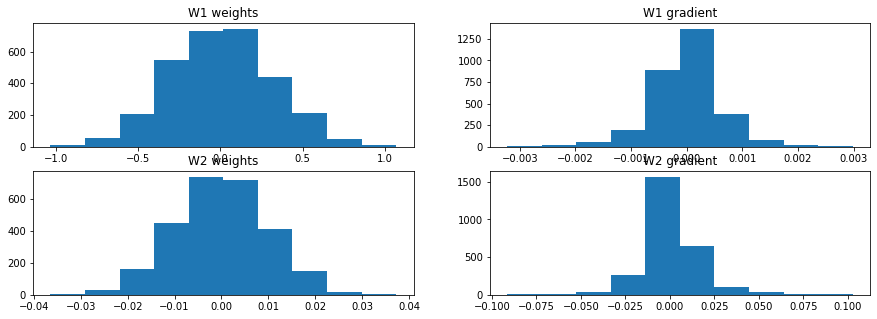

In [184]:
plt.figure(figsize=(15, 5))
plt.subplot(221)
plt.hist(W1.data.view(-1))
plt.title("W1 weights")
plt.subplot(222)
plt.hist(W1.grad.view(-1))
plt.title("W1 gradient")
plt.subplot(223)
plt.hist(W2.data.view(-1))
plt.title("W2 weights")
plt.subplot(224)
plt.hist(W2.grad.view(-1))
plt.title("W2 gradient")
plt.show()

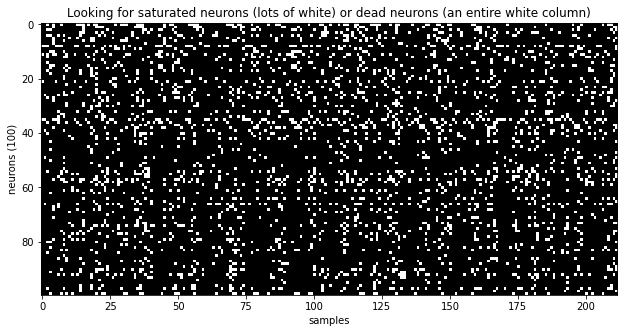

In [185]:
plt.figure(figsize=(20,5))
plt.title("Looking for saturated neurons (lots of white) or dead neurons (an entire white column)")
plt.ylabel(f"neurons ({layer1_neurons})"); plt.xlabel("samples")
plt.imshow(h.T.abs() > 0.99, cmap='gray', interpolation="nearest"); ##transposed for aesthetic convenience

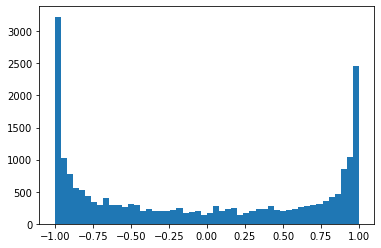

In [186]:
plt.hist(h.view(-1).tolist(), 50); ##saturated tanh neuron

## Batch Norm  
If we want unit gaussian weights throughout the NN (specifically in the hiden layers) we can just normalize them, since normalization is a differentiable process.  

Input to a batchnorm for a single neuron:  
- values of X over a minibatch, B.  
    - note: these are the values being outputted from the layer before, so they are not the raw inputs (for example, in the first layer they are X@W + b)  
- gamma (known as gain) and beta, params to be learned

Steps:  
- calculate the minibatch-mean and mini-batch variance (for each neuron in the layer)
- normalize/standardize the input values: for each xi, xi_norm = (xi - mean) / sqrt(var + epsilon) - epsilon to avoid div by 0 error
- scale and shift: scale the normalized inputs by gamma and shift by beta

Output: yi = gamma * xi_norm + beta

initialize the gain (gamma) with ones and bias (beta) with zeros. one for every neuron.  


Post-training:  
- we can calculate the batch norm mean and std dev for the entire training set and save those as set variables for run/test-time  
- or estimare them in a running manner during training (more common)  

Including a bias?  
- We do not need to include a bias for a layer that is receiving BN. Consider that, if we add a bias, we are then cancelling it out in the BN phase when we normalize all the data.  

In [6]:
# MAKING DATA & SPLITTING
block_size = 3
X, Y = make_data(words, block_size)

Xtr, Ytr, Xte, Yte = split_samples(X, Y, 0.8)
Xdev, Ydev, Xte, Yte = split_samples(Xte, Yte, 0.5)

print("Train:", Xtr.shape[0]/X.shape[0], 
      "Dev:", Xdev.shape[0]/X.shape[0],
      "Test:", Xte.shape[0]/X.shape[0])

print(X.shape)

 n_samples = 228146
Train: 0.7999964934734775 Dev: 0.10000175326326124 Test: 0.10000175326326124
torch.Size([228146, 3])


In [59]:
# INITIALIZE NN
g = torch.Generator().manual_seed(2147483647)
n_letters = len(stoi)


layer1_neurons = 100
emb_dim = 10

# torch.randn samples from normal dist. multiply by gain / sqrt(fan_in)
tanh_gain = 5/3
linear_gain = 1
C = torch.randn((n_letters, emb_dim), generator=g)
W1 = torch.randn((block_size*emb_dim, layer1_neurons), generator=g) * tanh_gain / (block_size*emb_dim)**0.5 #0.01
b1 = torch.randn(layer1_neurons, generator=g) * 0.01
W2 = torch.randn((layer1_neurons, n_letters), generator=g) * 0.01 #linear_gain / (layer1_neurons)**0.5
b2 = torch.randn(n_letters, generator=g) * 0.01

bngain = torch.ones((1, layer1_neurons))
bnbias = torch.zeros((1, layer1_neurons))

bnmean_running = torch.zeros((1, layer1_neurons))
bnstd_running = torch.zeros((1, layer1_neurons))
    
parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(f"Model params = { sum(p.nelement() for p in parameters) }")

for p in parameters:
    p.requires_grad = True

lossi = []

Model params = 6297


In [60]:
# TRAIN
batch_size = 64
steps = 10_000
use_batch_norm = True

for p in parameters:
    p.requires_grad = True

for i in range(steps):
    # Minibatch construct -----------------------------------------------------------------------------------
    if batch_size is not None:
        batch_ix = torch.randint(0, Xtr.shape[0], (batch_size, )) ##32 randints between 0 and length of data
    else:
        batch_ix=range(0,Xtr.shape[0])

    # Forward pass 
    ## Embedding layer
    emb = C[Xtr[batch_ix]] #character embeddings
    embcat = emb.view(emb.shape[0], -1) #concatenated

    ## Linear Layer -----------------------------------------------------------------------------------
    hpreact = embcat @ W1 #no bias incase we use batch norm

    ## BATCH NORM -----------------------------------------------------------------------------------
    if use_batch_norm:
        b1.requires_grad=False #since not using this bias
        if i==0: #check mean, std dev before BN
            with torch.no_grad():
                print(f"iter 1:\nbefore batch_norm - avg mean = {hpreact.mean(0).mean().item()}, avg std dev = {hpreact.std(0).mean().item()}")
        
        bnmeani = hpreact.mean(0, keepdim=True)
        bnstdi = hpreact.std(0, keepdim=True)
        # Batch norm (gain * normalized_hpreact + bias)
        hpreact = bngain * (( hpreact - bnmeani) /  (bnstdi + 1e-7)) + bnbias
        with torch.no_grad(): #update running bn means, stddevs
            bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
            bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

        if i==0: 
            with torch.no_grad():
                print(f"after batch_norm - avg mean = {hpreact.mean(0).mean().item()}, avg std dev = {hpreact.std(0).mean().item()}", end='\n')
    else:
        # if no batch norm, add the bias
        hpreact = hpreact + b1
    
    ## Nonlinearity -----------------------------------------------------------------------------------
    h = torch.tanh(hpreact)    #apply tanh
    logits = h @ W2 + b2       #calc logits

    # LOSS
    loss = F.cross_entropy(logits, Ytr[batch_ix]) #calc loss

    # Backward pass -----------------------------------------------------------------------------------
    for p in parameters:
        p.grad = None ##zero gradient
    loss.backward() ##backprop

    ## Update
    lr = 0.1 
    for p in parameters:
        if p.requires_grad==True:
            p.data += -lr * p.grad

    ## track stats
    lossi.append(loss.item())

    if i==0: print("\nstarting loss", loss.item()) ##print starting loss

print(loss.item(), end=" ")

iter 1:
before batch_norm - avg mean = -0.137224480509758, avg std dev = 1.5503087043762207
after batch_norm - avg mean = -9.825452673695168e-10, avg std dev = 0.9999999403953552

starting loss 3.2913782596588135
2.2333595752716064 

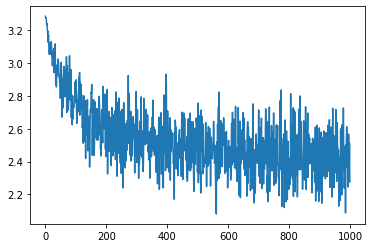

In [56]:
plt.plot(lossi);

In [57]:
# calibrate batch norm stats - as a second stage
with torch.no_grad():
    # Forward pass the entire training set
    emb = C[Xtr] #character embeddings
    embcat = emb.view(emb.shape[0], -1) #concatenated
    hpreact = embcat @ W1 + b1 #h pre-actiavtion    
    # Batch norm stats
    bnmean_final =  hpreact.mean(0, keepdim=True)
    bnstd_final = hpreact.std(0, keepdim=True)    

In [58]:
@torch.no_grad()
def split_loss(split, bnmean, bnstd):
    """Evalute model on desired split: train, val, or test"""
    x,y = {
        "train":(Xtr,Ytr),
        "val":(Xdev,Ydev),
        "test":(Xte, Yte)
    }[split]
    # Forward pass
    emb = C[x] #character embeddings
    embcat = emb.view(emb.shape[0], -1) #concatenated
    hpreact = embcat @ W1 + b1 #h pre-actiavtion
    # Batch norm (gain * normalized_hpreact + bias)
    hpreact = bngain * ( hpreact - bnmean ) / bnstd + bnbias
    h = torch.tanh(hpreact)    #apply tanh
    logits = h @ W2 + b2       #calc logits
    loss = F.cross_entropy(logits, y) #calc loss
    print(split, loss.item())
    # return loss


split_loss("train", bnmean_final, bnstd_final)     ##with post-training bn stats
split_loss("train", bnmean_running, bnstd_running) ##with running bn stats

train 2.413170337677002
train 2.445697069168091


In [ ]:
# Sample from the model
for _ in range(10):
    out_word = "."
    context = [0] * block_size ##initialize with all ...
    while True:
        emb = C[torch.tensor([context])] #(1,block_size,dim)
        h = torch.tanh( emb.view(-1, block_size*emb_dim) @ W1 + b1 )   
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix] ##shift and append
        out_word += itos[ix]
        if ix == 0:
            break
    print(out_word)